# Homework 10: Introduction to Pytorch

name: Ying Jiang

email: jiangyyy@umich.edu

This homework assignment took me XX hours in total to complete. (Please help us to gauge the difficulty of the assignment.)

## Collaboration Disclosure

In the cell below, please list *everyone* with whom you discussed any of the homework problems, excluding only the GSIs and the course instructor. 

If you did not discuss the homework with anyone else, write __"I did not discuss this homework with anyone."__

Even if you discuss questions with other, the code you submit must be only yours. All work is checked with the [MOSS plagiarism detector](https://theory.stanford.edu/~aiken/moss/).)

I did not discuss this homework with anyone.

## Submission Instructions
Your homework solutions should be written entirely in this Jupyter notebook file. Once it contains your solutions, you should submit this notebook through Canvas. Before submitting, please make sure make sure __Cells->Run__ executes without errors; errors in your code cause problems for our auto-grader. Thus, even though we may ask you to check for errors in your functions, you should not include in your submission any examples of your functions actually raising those errors.

## Nbgrader

We will be using nbgrader to grade your jupyter notebook. Additional tests will be used at grading time, you are encouraged to read the problem carefully and verify your code covers all appropriate cases.

This homework has a higher maximum time limit per cell as compared to previous homework. Please check that each cell of your notebook takes less __15 min__ to run. __Problem 1__ should be relatively fast (each cell should take < 2 min to run) and __Problem 2__ the training can take a bit longer but less __15 min__.

## Error checking

You do not need to do error checking (raising errors, etc.) in your code unless we explicitly ask you to so in a problem.

## Coding style
Please follow the [PEP8 guidelines](https://www.python.org/dev/peps/pep-0008/). The `pycodestyle_magic` package will remind you if you are not. To install it, run
```
pip install flake8 pycodestyle_magic
```
Once it is installed the following two Jupyter directives will enable syntax checking:

In [1]:
%load_ext pycodestyle_magic
%flake8_on --ignore E266 --max_line_length 99

## Problem 1: Building and training simple models with Pytorch (15 points) 
In this problem, you'll use **Pytorch** to build the loss functions for a pair of commonly-used statistical models. 

We will use variables $X$ and $Y$, which will serve as the predictor (independent variable) and response (dependent variable), respectively. Please use $W$ to denote a parameter that multiplies the predictor, and $b$ to denote a bias parameter (i.e., a parameter that is added).

In [1]:
# You will probably need these imports
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
from sklearn import datasets
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

### Part 1: Logistic regression (1 point)

In this model, which we discussed briefly in class, the binary variable $Y$ is distributed as a Bernoulli random variable with success parameter $\sigma(W^T X + b)$, where $\sigma(z) = (1+\exp(-z))^{-1}$ is the logistic function, $X \in R^6$ is the predictor random variable, and $W \in R^6, b \in R$ are the model parameters. 
 
Using **Pytorch** code, implement a class `LogisticRegression` that inherits from `nn.module`. This class should should have two attributes `w` and `b` which should be `nn.parameters` with shapes `(6,1)` and `(1)` respectivelly. 

This class should a method called `forward` that takes in the predictor random variable `x` with shape `(N, 6)`, where `N` is the number of observations, and returns the success parameter (also known as the prediction of our model on $Y$).

**Note:** Please initialize both `w, b` to be __all-one float tensors.__

In [3]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.w = nn.Parameter(torch.ones(6, 1))
        self.b = nn.Parameter(torch.ones(1))

    def forward(self, x):
        temp = torch.mm(x, self.w)+self.b
        y = (1+torch.exp(-temp))**(-1)
        return y

In [4]:
model = LogisticRegression()
assert type(model.w) == nn.Parameter
assert type(model.b) == nn.Parameter
x = torch.eye(6).float()
y = model.forward(x)
assert y.shape == (6, 1)
assert 0.86 < model.forward(x)[0].item() < 0.90

### Part 2: Negative log-likelihood loss (1 point)

Using **Pytorch** code, write a function called `neg_log` that takes in `y_true` (true value of $Y$) and `y_pred` (predicted value of $Y$) and returns the negative log-likelihood loss function. You can assume that both `y_true` and `y_pred` have shapes `N x 1` where `N` is the number of observations. 
 
 __Hint:__ The loss should be a negative log-likelihood term, summed over all the observations. Remember that $Y$ is Bernoulli distributed which should suggest what the likelihood is. 

In [5]:
def neg_log(y_true, y_pred):
    return -(torch.mm(y_true.T, torch.log(y_pred))+torch.mm((1-y_true).T, torch.log(1-y_pred)))

In [6]:
y_true = torch.tensor([1, 1, 1, 1, 1]).float().view(5, 1)
y_pred = torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5]).float().view(5, 1)
assert 3.4 < neg_log(y_true, y_pred).item() < 3.6

### Part 3: Estimating parameters in  logistic  regression (4 points) 

The four Numpy `.npy` files included along with the homework contain train and test data generated from a logistic model:

- `logistic_xtest.npy`: contains a 500-by-6 matrix whose rows are the independent variables (predictors) from the test set.
    
- `logistic_xtrain.npy`: contains a 2000-by-6 matrix whose rows are the independent variables (predictors) from the train set.
    
- `logistic_ytest.npy`: contains a binary 500-dimensional vector of dependent variables (responses) from the test set.
    
- `logistic_ytrain.npy`: contains a binary 2000-dimensional vector of dependent variables (responses) from the train set.
    
The $i$-th row of the matrix in `logistic_xtrain.npy` is the predictor for the response in the $i$-th entry of the vector in `logistic_ytrain.npy`, and analogously for the two test set files.

For this part you will obtain estimates of your `LogisticRegression` class model parameters $W$ and $b$ by minimizing the negative log-likelihood via gradient descent. Here is an outline of the steps:

- Load the training data.

- Create dataloaders for your training data, your dataloader should return `(x,y)` training pairs. You should specify `shuffle=True` and `batch_size=100` for its keyword arguments.

- Create a SGD optimizer with `lr=0.001` (learning rate).

- Runs the training loop for __500 epochs__. We recommend writing a separate function `train_loop` that takes in `lg_model` (your model), `optimizer` (the optimizer) and `train_dl_log` (the train dataloader) and runs the training loop for a single epoch. The training loops involves:
    - Iterates through dataloader to load data
    - Evaluates prediction loss on training pair
    - Propagates loss in the optimizer 
    - Return average loss over all pairs returned by the train dataloader. 
    
- Store the losses returned by each epoch of `train_loop` into a list called `losses`. 

   
__Note:__ We didn't discuss reading numpy data from files. To load the files, you can simply call `x_train = np.load('xtrain.npy')` to read the data into the variable `x_train`. `x_train` will be a Numpy array. You will then have to convert them to pytorch tensors.
   
__Another note:__ you'll have to play around with the learning rate and the number of steps. Here are two good ways to check if optimization is finding a good minimizer:
   
- Try printing the training data loss before and after optimization.
- Use the test data to validate your estimated parameters.

In [7]:
def train_loop(lg_model, optimizer, train_dl_log):
    loss_t = 0.0
    for i, (x, y) in enumerate(train_dl_log):
        y_pred = lg_model.forward(x)
        loss = neg_log(y, y_pred)
        lg_model.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_t += loss.item()
    return loss_t / len(train_dl_log)

In [8]:
# Load training data, run training, and create your list `losses` here.
train_x = np.load('logistic_xtrain.npy')
train_y = np.load('logistic_ytrain.npy')
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).float()
train_ds = TensorDataset(train_x, train_y)
train_dl_log = DataLoader(train_ds, shuffle=True, batch_size=100)

lg_model = LogisticRegression()
optimizer = torch.optim.SGD(lg_model.parameters(), lr=1e-3)

# run training
losses = []
for epoch in range(500):
    losses.append(train_loop(lg_model, optimizer, train_dl_log))

C:\Users\57277\anaconda3_2020\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


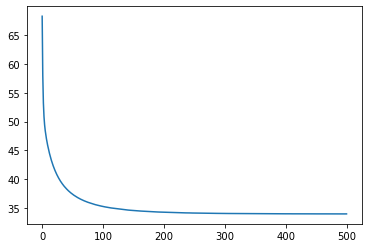

In [9]:
%matplotlib inline
# Check convergence of your loss here, 
plt.plot(losses)

In [10]:
assert losses[-1] < 40  # make sure your loss is low enough before continuing

In [11]:
b = lg_model.b.item()
assert b < 0

In [12]:
w = lg_model.w.detach().numpy()
assert w.shape == (6, 1)
w1 = w[0, 0].item()
assert 0.9 < w1 < 1.0

### Part 4: Evaluating your trained model (1 point)

Load the test data. What is the negative log-likelihood of your model on this test data? That is, what is the negative log-likelihood when you use your estimated parameters with the previously unseen test data? Store this value on a `float` variable `loss_test`.  Please use a `batch_size=500` and do not take an average, just sum the losses.

In [13]:
# Load test data and evaluate the loss of your trained model here.
test_x = np.load('logistic_xtest.npy')
test_y = np.load('logistic_ytest.npy')
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).float()
test_ds = TensorDataset(test_x, test_y)
test_dl_log = DataLoader(test_ds, shuffle=True, batch_size=500)

loss_test = 0.0
for i, (x, y) in enumerate(test_dl_log):
    y_pred = lg_model.forward(x)
    loss_test += neg_log(y, y_pred).item()

In [14]:
assert type(loss_test) == float

### Part 5 Evaluating the estimated logistic parameters (1 point) 

The data was, in reality, generated with 

$$ W = (1,1,2,3,5,8),~~~~~~ b = -1. $$
   
Write **Pytorch** expressions to compute the squared error between your estimated parameters and their true values. Store your results in variables `Wsqerr` and `bsqerr` respectively. 

__Note:__ you need only evaluate the error of your final estimates, not at every step.

In [15]:
w = torch.tensor([1, 1, 2, 3, 5, 8])
w_diff = w.view(6, -1)-lg_model.w
b = torch.tensor(-1)
Wsqerr = torch.mm(w_diff.T, w_diff)
Wsqerr = Wsqerr.item()
bsqerr = (b-lg_model.b)**2
bsqerr = bsqerr.item()

In [16]:
assert type(Wsqerr) == float
assert type(bsqerr) == float
assert 0.001 < bsqerr < 0.005

### Part 6  Classification  of  normally  distributed  data.  (4 points) 

There are four other `.npy` that are included with this homework. These files contain train and test data generated from $K=3$ different classes. Each class $k \in \{1,2,3\}$ has an associated mean $\mu_k \in R$ and variance $\sigma^2_k \in R$, and all observations from a given class are i.i.d. $\mathcal{N}(\mu_k,\sigma^2_k)$.

The four files are:

- `normal_xtest.npy`: contains a 500-vector whose entries are the independent variables (predictors) from the test set.

- `normal_xtrain.npy`: contains a 2000-vector whose entries are the independent variables (predictors) from the train set.

- `normal_ytest.npy`: contains a 500-by-3 dimensional matrix whose rows are one-hot encodings of the class labels for the test set.

- `normal_ytrain.npy`: contains a 2000-by-3 dimensional matrix whose rows are one-hot encodings of the class labels for the train set.
    
The $i$-th entry of the vector in `normal_xtrain.npy` is the observed random variable from class with label given by the $i$-th row of the matrix in `normal_ytrain.npy`, and analogously for the two test set files.

Load the training data and use it to obtain estimates of the vector of class means $\mu = (\mu_0,\mu_1,\mu_2)$ and variances $\sigma^2 = (\sigma^2_0, \sigma^2_1, \sigma^2_2)$ by minimizing the cross-entropy between the estimated normals and the one-hot encodings of the class labels (as we did in our softmax regression example in class). 

   
This time, instead of using gradient descent, use Adagrad, supplied by Pytorch as the function `torch.optim.Adagrad`. _Adagrad_ is a _stochastic gradient descent algorithm_, popular in machine learning. You can call this just like the gradient descent optimizer we used in class---just supply a learning rate. Documentation for the Pytorch implementation of Adagrad can be found here: https://pytorch.org/docs/stable/_modules/torch/optim/adagrad.html. See https://en.wikipedia.org/wiki/Stochastic_gradient_descent for more information about stochastic gradient descent and the Adagrad algorithm.

**Deliverables:** Create and name the corresponding variables `mu` and `sigma2`. As before, calculate the average loss in each epoch and return a list of `loss_norm` that can be used for plotting (averaged over the # of pairs returned by the dataloader, just like before). __Please make sure to do the following:__

- Initialize all mu's as all-zero tensors and the sigma2's as all-one tensors.

- Use `batch_size=100`

- Use a learning rate of __0.04__. 

- Run for __500__ epochs. 

	
__Note:__ you'll no longer be able to use the built-in logit cross-entropy that we used for training our models in lecture. Your cross-entropy for one observation should now look something like $ -\sum_k y'_k \log p_k,$ where $y'$ is the one-hot encoded vector and $p$ is the vector whose $k$-th entry is the (estimated) probability of the $k$-th observation given its class. 
   
__Another note:__ Do not include any estimation of the mixing coefficients (i.e., the class priors) in your model. You only need to estimate three means and three variances, because we are building a _discriminative_ model in this problem.

In [1]:
# Your code to create the model, load data, and train model goes here.
train_x = np.load('normal_xtrain.npy')
train_y = np.load('normal_ytrain.npy')
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).float()
train_ds = TensorDataset(train_x, train_y)
train_dl_log = DataLoader(train_ds, shuffle=True, batch_size=100)


# loss function:
def multiloss(a, y):
    loss = 0.0
    m = torch.mm(y, a.T)
    for i in range(y.shape[0]):
        loss -= m[i, i]
    return loss


# multilg_model
class multiLogisticRegression(nn.Module):
    def __init__(self):
        super(multiLogisticRegression, self).__init__()
        self.mu = nn.Parameter(torch.zeros(1, 3))
        self.sigma2 = nn.Parameter(torch.ones(1, 3))

    def forward(self, x):
        a0 = torch.distributions.normal.Normal(self.mu[0, 0],
                                               torch.sqrt(self.sigma2[0, 0])).log_prob(x)
        a1 = torch.distributions.normal.Normal(self.mu[0, 1],
                                               torch.sqrt(self.sigma2[0, 1])).log_prob(x)
        a2 = torch.distributions.normal.Normal(self.mu[0, 2],
                                               torch.sqrt(self.sigma2[0, 2])).log_prob(x)
        a = torch.cat((a0, a1, a2), dim=1)
        return a


multilg_model = multiLogisticRegression()
optimizer = torch.optim.Adagrad(multilg_model.parameters(), lr=0.04)


def train_loop(multilg_model, optimizer, train_dl_log):
    loss_t = 0.0
    for i, (x, y) in enumerate(train_dl_log):
        p = multilg_model.forward(x)
        loss = multiloss(p, y)
        multilg_model.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_t += loss.item()
    return loss_t / len(train_dl_log)


# run training
loss_norm = []
for epoch in range(500):
    loss_norm.append(train_loop(multilg_model, optimizer, train_dl_log))

mu = multilg_model.mu[0]
mu = mu.view(1, 3)

sigma2 = multilg_model.sigma2[0]
sigma2 = sigma2.view(1, 3)

NameError: name 'np' is not defined

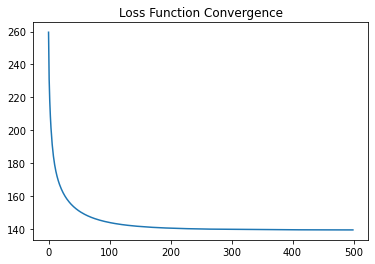

In [18]:
### Check convergence of your function.
plt.plot(loss_norm)
plt.title("Loss Function Convergence")
plt.show()

In [19]:
"""Check correctness of your final loss function."""
assert loss_norm[-1] < 150

In [20]:
assert type(mu) == torch.Tensor
assert mu.shape == (1, 3)
assert -1.1 < mu[0, 0].item() < -0.9

In [21]:
assert type(sigma2) == torch.Tensor
assert sigma2.shape == (1, 3)
assert sigma2[0, 0] < 0.55

### Part 7: Evaluating loss on test data (1 point) 
Load the test data. What is the cross-entropy of your model on this test data? That is, what is the cross-entropy when you use your estimated parameters with the previously unseen test data? Store your answer in a variable `loss_norm_test`. Please use a `batch_size=500` and do not take an average just sum the losses.

In [22]:
# Load test data and evaluate the loss of your trained model here.
test_x = np.load('normal_xtest.npy')
test_y = np.load('normal_ytest.npy')
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).float()
test_ds = TensorDataset(test_x, test_y)
test_dl_log = DataLoader(test_ds, shuffle=True, batch_size=100)

loss_norm_test = 0.0
for i, (x, y) in enumerate(test_dl_log):
    p = multilg_model.forward(x)
    loss_norm_test += multiloss(p, y).item()

In [23]:
assert type(loss_norm_test) == float
assert loss_norm_test < 800

### Part 8: Evaluating parameter estimation on test data (1 point) 

The true parameter values for the three classes were

\begin{equation*} \begin{aligned}
\mu_0 &= -1, \sigma_0^2 = 0.5 \\
\mu_1 &= 0, \sigma_1^2 = 1 \\
\mu_2 &= 3, \sigma_2^2 = 1.5.
\end{aligned} 
\end{equation*}

Write a **Pytorch** expression to compute the total squared error (i.e., summed over the six parameters) between your estimates and their true values. What is the squared error? Stored it in a variable `squared_error`. 

__Note:__ you need only evaluate the error of your final estimates, not at every step.

In [24]:
mu_t = torch.tensor([-1, 0, 3]).view(1, 3)
sigma2_t = torch.tensor([0.5, 1, 1.5]).view(1, 3)
squared_error = (torch.mm((mu - mu_t), (mu - mu_t).T) +
                 torch.mm((sigma2 - sigma2_t), (sigma2 - sigma2_t).T)).item()

In [25]:
assert type(squared_error) == float
assert squared_error < 0.030

### Part 9: Evaluating classification error on test data. (1 point)

Write and evaluate a **Pytorch** expression that computes the classification error of your estimated model averaged over the test data. Store your answer in a variable `error`. 

In [26]:
# verage
error = 0.0
for i, (x, y) in enumerate(test_dl_log):
    index_pred = multilg_model.forward(x).max(dim=1)[1]
    index_true = y.max(dim=1)[1]
    t = (index_pred == index_true).int().sum()
    error += 1 - (t/y.shape[0]).item()
error = error/len(test_dl_log)

In [27]:
assert type(error) == float
assert error < 0.40

## Problem 2 (15 points) 

Modify the Multilayer Perceptron implementation below to achieve a better performance. In particular,
- Your Validation and Test set accuracies should be >= 92%
- Answer the questions at the bottom of this notebook

Please read and execute this notebook first to make sure everything works correctly. Then, make any changes to the architecture, i.e., you can change

- the number of layers
- the activation function(s) (logistic sigmoid, tanh, relu, leaky relu, ...)
- the learning rate
- the number of hidden layers
- the number of units in the hidden layer(s)
- the number of epochs
- the minibatch size

However,

- don't change the weight initialization
- don't change the random seed
- don't change the optimization algorithm

### PIL
Note that Python's Imaging Library (PIL) can be installed via

    pip install pillow
    
### matplotlib 
Make sure that you have the latest version of matplotlib installed via 

    pip install matplotlib --upgrade
    
there is a bug in older versions that might cause an error during training. 

### Credit
This problem is based on a homework assignment written by Sebastian Raschka (sraschka@wisc.edu)
The dataset is from him too. Please do not distribute this modified version of his work.

In [28]:
import torch
import os
import pandas as pd
import numpy as np
import time
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [29]:

# if you suspect the initialization is off, you could try to change the random seed.
RANDOM_SEED = 123

# If there is a GPU available, it will use it,
# otherwise, it will use the CPU
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

**Note:** I actually noticed that this code runs faster on the CPU than on the GPU, because the dataset is so small. However, you are encouraged to try out training on a GPU if you are interested, e.g., via Google Colab.

### Loading test
The dataset consists of 3 classes:
- Drawings of "birds" (class 0)
- Drawings of "pizzas" (class 1)
- Drawings of "screwdrivers" (class 2)

(The dataset is based on Google Quickdraw: I wrote a script to fetch the images from the database here: https://quickdraw.withgoogle.com/data)

The dataset is very small on purpose so that the training should be relatively fast (but this wouldn't be an ideal DL dataset because of its small size).

In [30]:
df_train = pd.read_csv('train.csv')
print('Class distribution Train', np.bincount(df_train['Class Label'].values))

Class distribution Train [8005 7669 6826]


The images are 28x28 dimensional (grayscale).

**Important:** Make sure you unzip the file `png_files.zip` that should have been contained in the file you downloaded from Canvas.

Some examples:

png_files\bird_000043.png


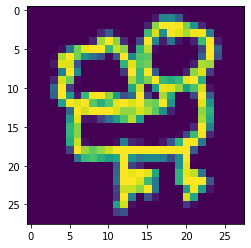

png_files\bird_000107.png


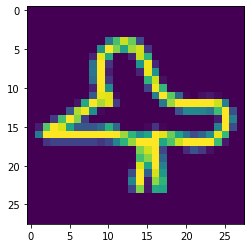

png_files\pizza_000000.png


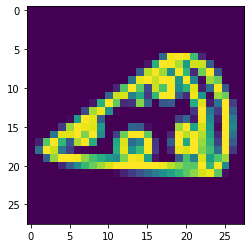

png_files\pizza_000002.png


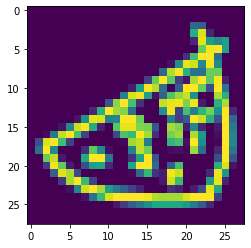

png_files\screwdriver_000001.png


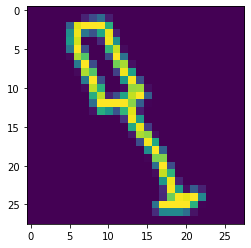

png_files\screwdriver_000012.png


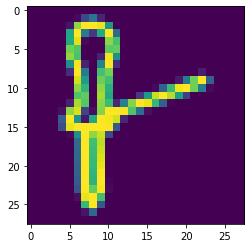

In [31]:
%matplotlib inline
import glob
for i in (12, 25, 30000, 30001, 60000, 60005): 
    image_paths = sorted(glob.glob('png_files/*.png'))
    im_path = image_paths[i]
    print(im_path)
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()
    plt.close()

### Setup dataset and dataloaders

- The only thing you should change in this section during experimenting is the batch size
- However, it is not necessary to make changes to the batch size for your solution to work. 

In [32]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['Filename'].values
        self.y = df['Class Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                         self.img_names[index]))

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [33]:
# CHANGE IF YOU LIKE, keep variable name the same.
# NOTE: Using more workers might help make training faster. It depends on your computer.
# feel free to experiment and see what works.
BATCH_SIZE = 64
N_WORKERS = 0

In [34]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally
custom_transform = transforms.Compose([transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='train.csv',
                                 img_dir='png_files/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=N_WORKERS)


valid_dataset = QuickdrawDataset(csv_path='valid.csv',
                                 img_dir='png_files/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS)

test_dataset = QuickdrawDataset(csv_path='test.csv',
                                img_dir='png_files/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=N_WORKERS)

The cell below just checks if the dataset can be loaded correctly.

**Note:** Make sure you unzip the file `png_files.zip` that should have been contained in the file you downloaded from Canvas.

In [35]:
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):

        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])

        x = x.to(DEVICE)
        y = y.to(DEVICE)

        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 64
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 64
break minibatch for-loop


If you get an error, make sure the `png_files.zip` file is in the same directory as this notebook and that it was unzipped correctly.

### Multilayer Perceptron Model (You need to make changes in this section)

The cell below contains the multi-layer perceptron model. **This is the main section where you want to make changes to the architecture.**

In [45]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_classes):
        super(MLP, self).__init__()

        self.num_classes = num_classes

        # ADD ADDITIONAL LAYERS BELOW IF YOU LIKE
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_out = torch.nn.Linear(num_hidden_1, num_classes)

    def forward(self, x):
        # MAKE SURE YOU CONNECT THE LAYERS PROPERLY IF YOU CHANGED
        # ANYTHNG IN THE __init__ METHOD ABOVE
        out = self.linear_1(x)
        out = F.relu(out)
        out = torch.tanh(out)
        # out = torch.sigmoid(out)
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas


# Model Initialization
# You should keep the variable names 'model' and 'optimizer' created below.


# the random seed makes sure that the random weight initialization
# in the model is always the same.
# In practice, some weights don't work well, and we may also want
# to try different random seeds. In this homework, this is not
# necessary.
torch.manual_seed(RANDOM_SEED)

# IF YOU CHANGED THE ARCHITECTURE ABOVE, MAKE SURE YOU
# ACCOUNT FOR IT VIA THE PARAMETERS BELOW. I.e., if you
# added a second hidden layer, you may want to add a
# hidden_2 parameter here. Also you may want to play
# with the number of hidden units.
model = MLP(num_features=28*28,
            num_hidden_1=70,
            num_classes=3)

model = model.to(DEVICE)


# For this homework, do not change the optimizer. However, you
# likely want to experiment with the learning rate!
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [37]:
"""You can ignore this cell. You can remove the NotImplementedError() if you want
but this won't affect the grading."""
# YOUR CODE HERE

"You can ignore this cell. You can remove the NotImplementedError() if you want\nbut this won't affect the grading."

### Training

In [38]:
# DO NOT make changes to this cell

def compute_epoch_loss(model, data_loader):
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model.forward(features)
            predicted_labels = torch.argmax(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100


start_time = time.time()
minibatch_cost = []
epoch_cost = []

__No need to change anything below, However, you can change the number of epochs if you like.__

In [39]:
NUM_EPOCHS = 25  # You can change if you like. 

In [40]:
# DO NOT make changes.
def run_training():
    for epoch in range(NUM_EPOCHS):
        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)

            # FORWARD AND BACK PROP
            logits, probas = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()
            cost.backward()
            minibatch_cost.append(cost)

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            if not batch_idx % 50:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                      % (epoch+1, NUM_EPOCHS, batch_idx,
                         len(train_loader), cost))

        model.eval()
        cost = compute_epoch_loss(model, train_loader)
        epoch_cost.append(cost)

        train_accuracy = compute_accuracy(model, train_loader)
        valid_accuracy = compute_accuracy(model, valid_loader)

        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, NUM_EPOCHS, cost))
        print('Train Accuracy: %.3f | Validation Accuracy: %.3f'
              % (train_accuracy, valid_accuracy))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    return train_accuracy, valid_accuracy

### Evaluation (Make no changes in this section)

In [41]:
# DO NOT make changes.
def evaluation():
    plt.plot(range(len(minibatch_cost)), minibatch_cost)
    plt.ylabel('Cross Entropy')
    plt.xlabel('Minibatch')
    plt.show()

    plt.plot(range(len(epoch_cost)), epoch_cost)
    plt.ylabel('Cross Entropy')
    plt.xlabel('Epoch')
    plt.show()

    test_accuracy = compute_accuracy(model, test_loader)

    print('Test Accuracy: %.2f' % test_accuracy)
    return test_accuracy

### Conclusions (YOUR ANSWERS REQUIRED)

#### Question 1 ( 10 points) 
In this part we will check that your training/validation/testing accuracies are correct. As stated at the beginning of the problem, for full credit your validation and test accuracy must be >= 92%. 

**Note:** Do NOT change any of the following three cells in this question or add any new cells. Doing so will result in an automatic point deduction.

Epoch: 001/025 | Batch 000/352 | Cost: 1.0932
Epoch: 001/025 | Batch 050/352 | Cost: 0.7527
Epoch: 001/025 | Batch 100/352 | Cost: 0.5252
Epoch: 001/025 | Batch 150/352 | Cost: 0.5128
Epoch: 001/025 | Batch 200/352 | Cost: 0.4043
Epoch: 001/025 | Batch 250/352 | Cost: 0.3703
Epoch: 001/025 | Batch 300/352 | Cost: 0.3543
Epoch: 001/025 | Batch 350/352 | Cost: 0.2867
Epoch: 001/025 Train Cost: 0.4088
Train Accuracy: 85.702 | Validation Accuracy: 86.160
Time elapsed: 1.03 min
Epoch: 002/025 | Batch 000/352 | Cost: 0.4458
Epoch: 002/025 | Batch 050/352 | Cost: 0.3340
Epoch: 002/025 | Batch 100/352 | Cost: 0.4569
Epoch: 002/025 | Batch 150/352 | Cost: 0.5200
Epoch: 002/025 | Batch 200/352 | Cost: 0.3524
Epoch: 002/025 | Batch 250/352 | Cost: 0.2924
Epoch: 002/025 | Batch 300/352 | Cost: 0.3220
Epoch: 002/025 | Batch 350/352 | Cost: 0.5392
Epoch: 002/025 Train Cost: 0.3362
Train Accuracy: 88.844 | Validation Accuracy: 88.480
Time elapsed: 1.72 min
Epoch: 003/025 | Batch 000/352 | Cost: 0.217

Epoch: 018/025 | Batch 100/352 | Cost: 0.0638
Epoch: 018/025 | Batch 150/352 | Cost: 0.1696
Epoch: 018/025 | Batch 200/352 | Cost: 0.1364
Epoch: 018/025 | Batch 250/352 | Cost: 0.1920
Epoch: 018/025 | Batch 300/352 | Cost: 0.1717
Epoch: 018/025 | Batch 350/352 | Cost: 0.2502
Epoch: 018/025 Train Cost: 0.1585
Train Accuracy: 95.200 | Validation Accuracy: 92.000
Time elapsed: 11.54 min
Epoch: 019/025 | Batch 000/352 | Cost: 0.1069
Epoch: 019/025 | Batch 050/352 | Cost: 0.2400
Epoch: 019/025 | Batch 100/352 | Cost: 0.0944
Epoch: 019/025 | Batch 150/352 | Cost: 0.2820
Epoch: 019/025 | Batch 200/352 | Cost: 0.2020
Epoch: 019/025 | Batch 250/352 | Cost: 0.1835
Epoch: 019/025 | Batch 300/352 | Cost: 0.2277
Epoch: 019/025 | Batch 350/352 | Cost: 0.1366
Epoch: 019/025 Train Cost: 0.1464
Train Accuracy: 95.724 | Validation Accuracy: 92.200
Time elapsed: 12.13 min
Epoch: 020/025 | Batch 000/352 | Cost: 0.1075
Epoch: 020/025 | Batch 050/352 | Cost: 0.1341
Epoch: 020/025 | Batch 100/352 | Cost: 0.0

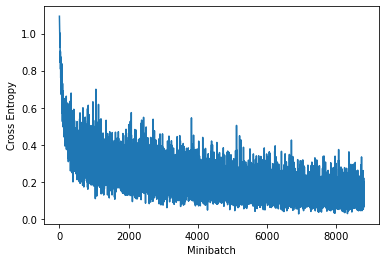

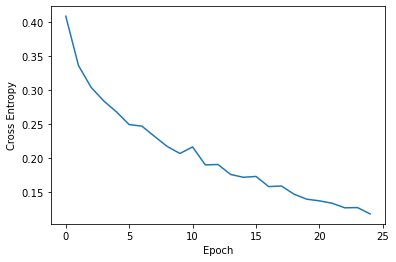

Test Accuracy: 92.11


In [42]:
train_accuracy, valid_accuracy = run_training()
test_accuracy = evaluation()

In [43]:
assert train_accuracy >= 90
assert valid_accuracy >= 90
assert test_accuracy >= 90

In [44]:
assert train_accuracy >= 92
assert valid_accuracy >= 92
assert test_accuracy >= 92

#### Question 2 (2 points)

Do you notice any overfitting? If yes, why do you think your model is overfitting, and what would be a simple technique to reduce overfitting?

Yes. 
At first, I set the epoch=30 and found that although the train accracy is getting bigger, the validation accracy would go over 0.92 and down again. So my epoch is 25 now.
Early stopping, dropout and regularization.

#### Question 2 (3 points)
What architectual changes did you make to improve the performance? Briefly list them below.

my MLP model now is 
a linear_1 layer (with num_hidden_1=70), a relu layer, a tanh layer, a linear_out layer and a softmax layer.

BATCH_SIZE = 64
N_WORKERS = 0